## Data preparation and understanding



In [0]:
#Load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.style.use('ggplot')

In [251]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
#Load the data
train = pd.read_csv('/content/drive/My Drive/机器学习/lab5/train.csv')
test = pd.read_csv('/content/drive/My Drive/机器学习/lab5/test.csv')
all_data = pd.concat([train, test], ignore_index = True, sort=False)
PassengerId=test['PassengerId']

#Print the first 5 rows of the dataframe.
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [253]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  749 non-null    int64  
 1   Survived     749 non-null    int64  
 2   Pclass       749 non-null    int64  
 3   Name         749 non-null    object 
 4   Sex          749 non-null    object 
 5   Age          596 non-null    float64
 6   SibSp        749 non-null    int64  
 7   Parch        749 non-null    int64  
 8   Ticket       749 non-null    object 
 9   Fare         749 non-null    float64
 10  Cabin        174 non-null    object 
 11  Embarked     748 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 70.3+ KB


In [254]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,749.000000,749.000000,749.000000,596.000000,749.000000,749.000000,749.000000
mean,375.000000,0.388518,2.295060,30.019715,0.523364,0.373832,33.468658
std,216.361965,0.487739,0.838409,14.522089,1.048835,0.805502,52.387040
min,1.000000,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,188.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,375.000000,0.000000,3.000000,28.000000,0.000000,0.000000,15.045800
75%,562.000000,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,749.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [255]:
train['Survived'].value_counts()

0    458
1    291
Name: Survived, dtype: int64

##  Preliminary analysis of features

**Sex Feature：The survival rate of women is much higher than that of men**

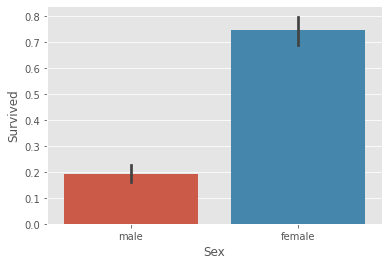

In [256]:
sns.barplot(x="Sex", y="Survived", data=train)

**Pclass Feature：The higher the passenger social rank(Pclass), the higher the survival rate**




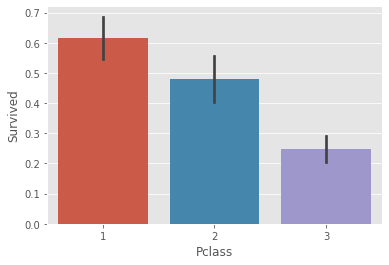

In [257]:
sns.barplot(x="Pclass", y="Survived", data=train)

**SibSp Feature：Passengers with moderate spouses and siblings have a higher survival rate**

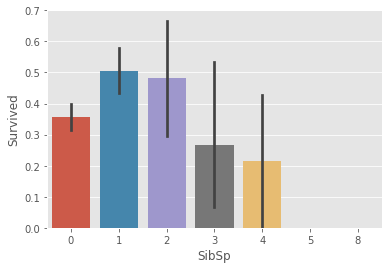

In [258]:
sns.barplot(x="SibSp", y="Survived", data=train)

**Parch Feature: Passengers with moderate parents and children have a higher survival rate**

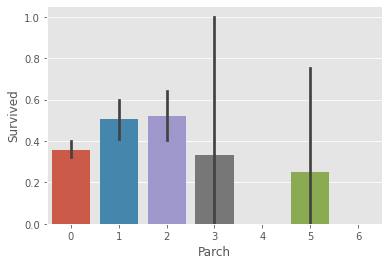

In [259]:
sns.barplot(x="Parch", y="Survived", data=train)

It can be seen from the density maps of different survivors that the **survival rate is significantly different on the left side of the age of 15 years**. The area of the non-crossing area of the density map is very large, but in other ages, the difference is not very obvious Therefore, it may be considered to separate this younger area.

Text(13.310937500000009, 0.5, 'density')

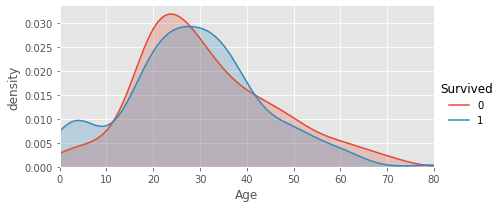

In [260]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 

**Embarked : Port and Survival Analysis**

Result analysis: The survival rate of C land is higher, and this should also be retained as a model feature.

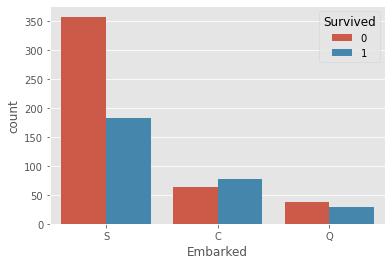

In [261]:
sns.countplot('Embarked',hue='Survived',data=train)

##  Data cleaning

### Age

The Age column has missing values, filled with the median

In [0]:
# 用中值填补缺失值
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())

### Embarked Feature

Embarked missing amount is 2, passengers missing Embarked information have Pclass of 1, and Fare are both 80, because the median Fare of passengers with Embarked C and Pclass of 1 is 80, so missing values are filled with C.

In [263]:
all_data[all_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,NaN,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [264]:
all_data.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           78.2667
        Q           90.0000
        S           52.0000
2       C           24.0000
        Q           12.3500
        S           13.5000
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [0]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

### Sex

The values of Sex column male and female cannot be directly processed, and they are converted to 0 and 1

In [266]:
print(all_data['Sex'].unique())

['male' 'female']


In [0]:
all_data.loc[all_data['Sex'] == 'male', 'Sex'] = 0
all_data.loc[all_data['Sex'] == 'female', 'Sex'] = 1

## Feature Engineering

**Title Feature(New):**

Passengers with different titles have different survival rates. 

The Title feature is added to extract the passenger's title from the name.

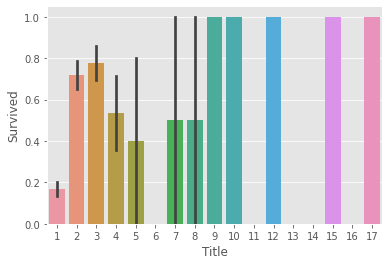

In [268]:
# 提炼新特征
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ''


titles = all_data['Name'].apply(get_title)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 8, "Mlle": 9,
                 "Mme": 10, "Don": 11, "Lady": 12, "Countess": 13, "Jonkheer": 14, "Sir": 15, "Capt": 16, "Ms": 17
                 }
for k, v in title_mapping.items():
    titles[titles == k] = v
    
#print(pd.value_counts(titles))
all_data['Title'] = titles
sns.barplot(x="Title", y="Survived", data=all_data)

**FamilyLabel Feature(New)：**

Passengers with a family size of 2 to 4 have a higher survival rate

Add the FamilyLabel feature, first calculate FamilySize = Parch + SibSp + 1, and then divide the FamilySize into three categories.

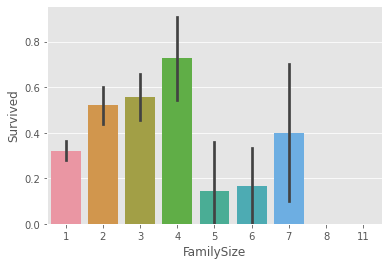

In [269]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data)

The FamilySize is divided into three categories according to the survival rate, forming the FamilyLabel feature.

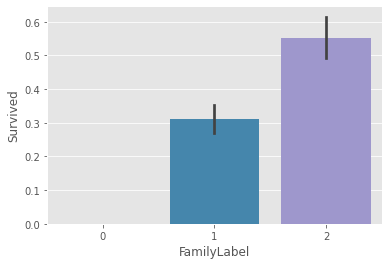

In [270]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data)

**Deck Feature(New)：**

Different decks have different survival rates.

Added Deck feature, first fill Cabin vacancy value with 'Unknown', then extract the first letter in Cabin to form the passenger's deck number.

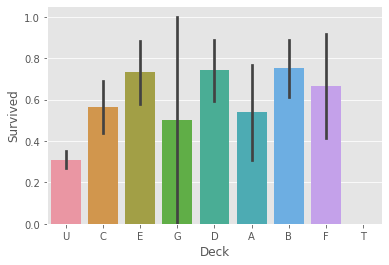

In [271]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data)

**TicketGroup Feature (New):**

Passengers who share ticket numbers with 2 to 4 people have a higher survival rate.

Added TicketGroup feature to count the total number of tickets for each passenger.

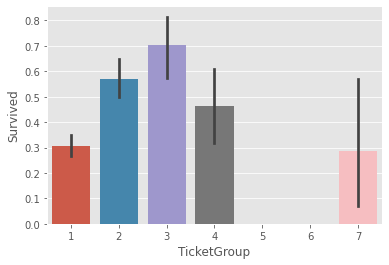

In [272]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

TicketGroup is divided into three categories according to survival rate.

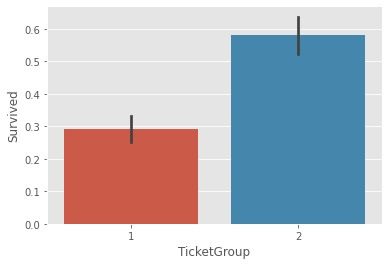

In [273]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

**NameLength(New):**

the length of the name, the longer the foreign name, the higher the status

In [0]:
all_data['NameLength'] = all_data['Name'].apply(lambda x: len(x))

In [275]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel,Deck,TicketGroup,NameLength
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,Unknown,S,1,2,2,U,1,23
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,3,2,2,C,1,51
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,2,1,1,U,1,22
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,3,2,2,C,2,44
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,Unknown,S,1,1,1,U,1,24


### Feature conversion
Select features, convert to numerical variables, and divide the training set and test set.

In [0]:
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup',	'NameLength']]
all_data=pd.get_dummies(all_data)

train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)

X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

In [277]:
train.head()

,Survived,Pclass,Age,Fare,FamilyLabel,TicketGroup,NameLength,Sex_0,Sex_1,Embarked_C,Embarked_Q,Embarked_S,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,Title_10,Title_11,Title_12,Title_13,Title_14,Title_15,Title_16,Title_17,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0.0,3,22.0,7.2500,2,1,23,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,71.2833,2,1,51,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,1,1,22,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,1,35.0,53.1000,2,2,44,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.0,3,35.0,8.0500,1,1,24,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## LogisticRegression

In [278]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5,scoring='accuracy')
print(scores)
print(scores.mean())

[0.76       0.80666667 0.86       0.78       0.81879195]
0.8050917225950783


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## RandomForestClassifier

The randomness of the random forest is reflected in two points: 
1. The sampling is random, and there are replacements. 
2. The selection of features is random. Not all attribute features are necessarily used. 

Forest representation generates multiple decision trees.


In [279]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=2)
kf = KFold(n_splits=3, random_state=1)
scores = cross_val_score(clf, X_train, y_train, cv=kf ,scoring='accuracy')

print(scores)
print(scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.82       0.844      0.80321285]
0.8224042838018741


In [0]:
clf.fit(X_train, y_train)
predictions = clf.predict(test)

test_new = pd.read_csv('/content/drive/My Drive/机器学习/lab5/test.csv')
test_new["Survived"] = predictions.astype(np.int32)
test_new.to_csv("/content/drive/My Drive/机器学习/lab5/test_new.csv", index=False)